In [846]:
'''
Select a dataset:

max_length: max video length in seconds – use 'inf' for the videos initial length
selector: selects one of the full-length datasets 
dataset: name format of the folder is dataset_compression_videos

'''

max_length = 9.5 #'inf'
selector = 2
dataset = [ 'faceshifter_c23_100',    # 0
            'faceshifter_raw_100',    # 1
            'faceshifter_raw_200',    # 2
            
            'neuraltextures_c23_100', # 3
            'neuraltextures_raw_100', # 4
           ]

'''
Folders and options
'''
# video statistics (e.g. FPS per video)
path_video_stats_manipulated = '2_rPPG/'+dataset[selector]+'/stats/video_statistics_manipulated.csv'
path_video_stats_original = '2_rPPG/'+dataset[selector]+'/stats/video_statistics_original.csv'

# GRGB folders
path_GRGB_manipulated = '2_rPPG/'+dataset[selector]+'/manipulated'
path_GRGB_original = '2_rPPG/'+dataset[selector]+'/original'

# lowcut = 0.65  # Low cut-off frequency (Hz) = 39 BPM [1]
# highcut = 4.0  # High cut-off frequency (Hz) = 240 BPM [1]

'''
Implemented features:
- katz:     Katz Fractal Dimension [2]
- svd:      SVD Entropy [3]
- higuchi:  Higuchi Fractal Dimension [3]
- petros:   Petrosian Fractal Dimension [3]
- zero:     Zero-Crossings (after signal normalization) [3]

- dfa:      Detrended Fluctuation Analysis
- bpm:      BPM (using peak detection)

References:
[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243
[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929
[3] Boccignone, G., Bursic, S., Cuculo, V., D’Amelio, A., Grossi, G., Lanzarotti, R., & Patania, S. (2022). Deepfakes have no heart: A simple rppg-based method to reveal fake videos. In International Conference on Image Analysis and Processing (pp. 186-195). Springer International Publishing. https://doi.org/10.1007/978-3-031-06430-2_16

'''


'\nImplemented features:\n- katz:     Katz Fractal Dimension [2]\n- svd:      SVD Entropy [3]\n- higuchi:  Higuchi Fractal Dimension [3]\n- petros:   Petrosian Fractal Dimension [3]\n- zero:     Zero-Crossings (after signal normalization) [3]\n\n- dfa:      Detrended Fluctuation Analysis\n- bpm:      BPM (using peak detection)\n\nReferences:\n[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243\n[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929\n[3] Boccignone, G., Bursic, S., Cuculo, V., D’Amelio, A., Grossi, G., Lanzarotti, R., & Patania, S. (2022). Deepfakes have no heart: A simple rppg-based method to reveal fake videos

In [847]:
''' Various functions '''

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import antropy as ant

# load data
stats_original = pd.read_csv(path_video_stats_original)
stats_manipulated = pd.read_csv(path_video_stats_manipulated)

def get_fps(filename, df):
    filename = filename.strip()
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
def get_fps2(filename, df):
    filename = int(filename.strip()) # INT
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
def get_csvs(root_folder):
    csv_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('.csv')):
                file_path = os.path.join(root, file)
                csv_list.append(file_path)
    return csv_list

def extract_filename(file_path):
    match = re.search(r'([^/]+)\.csv$', file_path) # filename pattern (e.g., "002_006")
    if match:
        return match.group(1)
    else:
        return None
    
''' 
FILTER 
'''
def bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') 
    y = filtfilt(b, a, data)
    return y

''' 
BPM detection
'''
def get_bpm_peaks(data,fps):
    peaks, _ = find_peaks(data, distance=fps/2)
    peak_intervals = np.diff(peaks) / fps
    heart_rate = 60.0 / np.mean(peak_intervals)
    return heart_rate

In [848]:
import os

def count_files_in_folder(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        num_files = len(files)
        print(f"There are {num_files} files in the folder '{folder_path}'.")
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

count_files_in_folder(path_GRGB_manipulated)
count_files_in_folder(path_GRGB_original)

There are 200 files in the folder '2_rPPG/faceshifter_raw_200/manipulated'.
There are 200 files in the folder '2_rPPG/faceshifter_raw_200/original'.


In [849]:
df_manipulated = pd.DataFrame(columns=['bpm', 'zero','katz','svd','dfa','higuchi','petros']) #,'len'
csv_list_manipulated = get_csvs(path_GRGB_manipulated)

for i in csv_list_manipulated:
    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None).transpose()
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")
        continue
    
    rPPG_signal = rPPG_signal_raw.dropna()
    fps = get_fps(filename,stats_manipulated)
    
    if len(rPPG_signal) < 30:
        print(f"Excluded due to short length: {filename}")
        continue
    
    #rPPG_signal_filter = bandpass_filter(rPPG_signal[0], lowcut, highcut, fps)
    #rPPG_signal_filter = (rPPG_signal_filter - np.mean(rPPG_signal_filter)) / np.std(rPPG_signal_filter)
    rPPG_signal = rPPG_signal[0] # only the raw GRGB signal is used, according to [3]
    
    # truncate the signal if max_length has been specified
    if isinstance(max_length, int):
        rPPG_signal = rPPG_signal[:int(max_length * fps)]

    df_manipulated.loc[filename, 'bpm'] = get_bpm_peaks(rPPG_signal, fps)
    df_manipulated.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal)
    df_manipulated.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal, normalize=True)
    df_manipulated.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal)
    df_manipulated.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal)
    df_manipulated.loc[filename, 'petros'] = ant.petrosian_fd(rPPG_signal)
    #df_manipulated.loc[filename, 'len'] = len(rPPG_signal)/fps

    # zero-crossings are affected by the signals normalization!
    rPPG_signal = (rPPG_signal - np.mean(rPPG_signal)) / np.std(rPPG_signal)
    df_manipulated.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal)

Excluded due to empty file: 096_101
Excluded due to empty file: 456_435
Excluded due to short length: 221_206


In [850]:
df_original = pd.DataFrame(columns=['bpm', 'zero','katz','svd','dfa','higuchi','petros']) #,'len'
csv_list_original = get_csvs(path_GRGB_original)

for i in csv_list_original:
    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None).transpose()
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")
        continue

    rPPG_signal = rPPG_signal_raw.dropna()

    fps = get_fps2(filename, stats_original)
    
    if fps is None:
        print(f"Excluded due to None FPS: {filename}")
        continue  # Skip this iteration if FPS is None
    
    if len(rPPG_signal) < 30:
        print(f"Excluded due to short length: {filename}")
        continue

    # rPPG_signal_filter = bandpass_filter(rPPG_signal[0], lowcut, highcut, fps)
    # rPPG_signal = (rPPG_signal_filter - np.mean(rPPG_signal_filter)) / np.std(rPPG_signal_filter)
    rPPG_signal = rPPG_signal[0] # only the raw GRGB signal is used, according to [3]
    
    # truncate the signal if max_length has been specified
    if isinstance(max_length, int):
        rPPG_signal = rPPG_signal[:int(max_length * fps)]

    df_original.loc[filename, 'bpm'] = get_bpm_peaks(rPPG_signal, fps)
    df_original.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal)
    df_original.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal, normalize=True)
    df_original.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal)
    df_original.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal)
    df_original.loc[filename, 'petros'] = ant.petrosian_fd(rPPG_signal)
    #df_original.loc[filename, 'len'] = len(rPPG_signal)/fps
    # zero-crossings are affected by the signals normalization!
    rPPG_signal = (rPPG_signal - np.mean(rPPG_signal)) / np.std(rPPG_signal)
    df_original.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal)

Excluded due to empty file: 221
Excluded due to empty file: 096
Excluded due to empty file: 456


In [851]:
''' Balance of data? '''
print(f"{len(df_manipulated)} \t manipulated")
print(f"{len(df_original)} \t original")

197 	 manipulated
197 	 original


# ——— SVM

In [852]:
df_original['label'] = 'original'
df_manipulated['label'] = 'manipulated'
df_combined = pd.concat([df_original, df_manipulated])

In [853]:
# ''' Inspect Feature Combination (Graphs) '''

# def plot(x,y, alpha):
#     plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=alpha)
#     plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=alpha)
#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title(dataset[selector])
#     plt.legend()
#     plt.show()
# plot('katz','svd', 1)
# plot('katz','higuchi', 1)
# plot('svd','higuchi', 1)

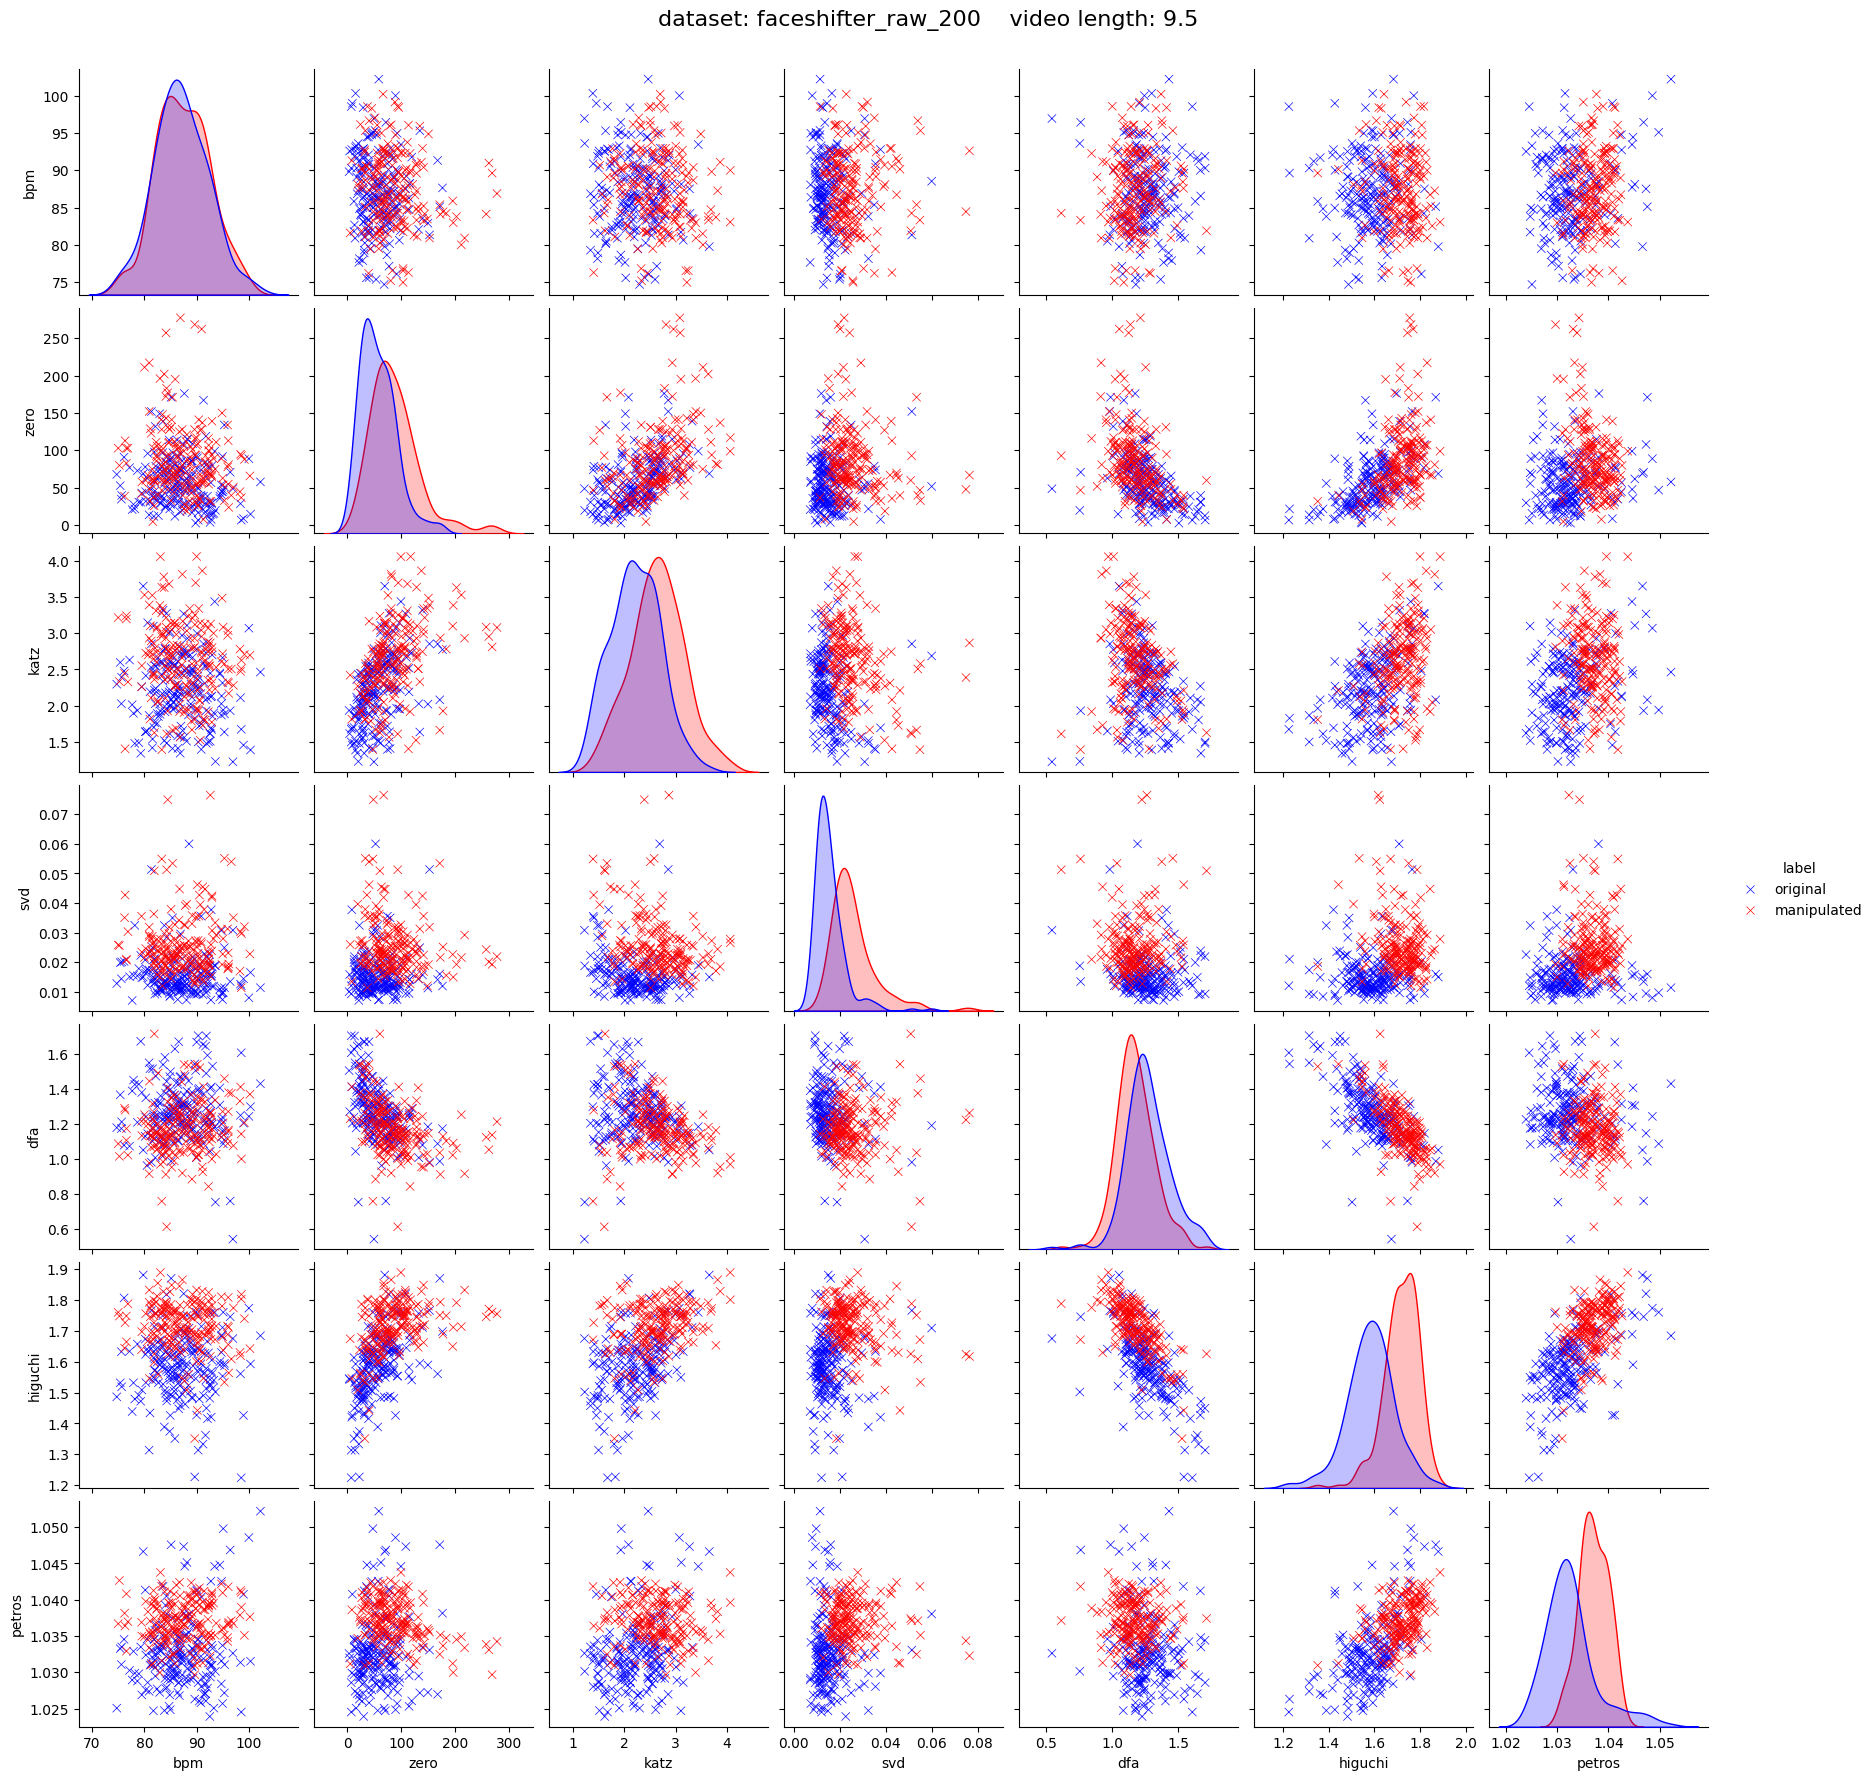

In [854]:
''' Inspect Feature Combination (Matrix) '''

import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = {
    'manipulated': 'red',
    'original': 'blue'
}
custom_markers = {'manipulated': 'x', 'original': 'x'}  

g = sns.pairplot(df_combined, hue='label', palette=custom_palette, markers=custom_markers)
g.fig.suptitle(f"dataset: {dataset[selector]}    video length: {max_length}", y=1.02,fontsize=16)

plt.show()


In [855]:
''' 
INITIAL ACCURACY
Test accuracy with feature normalization and standard parameters
'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = df_combined.drop('label', axis=1) # All features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

# split dataset into training and testing sets, ratio: 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

# evaluate model on the test set
accuracy = model.score(X_test, y_test)
print("Test accuracy with feature normalization and standard parameters")
print(f"test accuracy for {dataset[selector]}: {accuracy:.2f}")
print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )

Test accuracy with feature normalization and standard parameters
test accuracy for faceshifter_raw_200: 0.91
percentage: 90,76%


In [856]:
''' 
CONFUSION MATRIX 
'''
from sklearn.metrics import confusion_matrix

svm_predicted = model.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted,labels=['manipulated', 'original'])
print(confusion)

[[49  2]
 [ 9 59]]


In [857]:
''' 
FEATURE SELECTION:
Measures how much each feature contributes to the model's decision boundary.
For linear SVM models – model-based coefficients

'''
feature_names = df_combined.columns.tolist()  # Convert column names to a list

# ensure model has a linear kernel (since coef_ only works for linear kernels)
if hasattr(model, 'coef_'):
    # extract feature importance (weights of the linear SVM)
    feature_importance = np.abs(model.coef_[0])

    # pair feature importance with feature names
    feature_importance_with_names = sorted(zip(feature_importance, feature_names), reverse=True)

    # sisplay sorted feature importance
    print("Feature – Importance for model:\n")
    for importance, name in feature_importance_with_names:
        print(f"{importance:.2f} \t {name}")
else:
    raise AttributeError("The model does not support feature importance extraction (only works for linear kernels).")

Feature – Importance for model:

1.45 	 svd
1.31 	 higuchi
0.60 	 katz
0.45 	 dfa
0.19 	 petros
0.16 	 zero
0.06 	 bpm


In [858]:
''' 
FEATURE SELECTION:
Measures the statistical significance of each feature's relationship with the target label.
For all model types – uses ANOVA

'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
import pandas as pd

X = df_combined.drop('label', axis=1)  # All features
Y = df_combined['label']  # Target labels

# feature extraction
test = SelectKBest(score_func=f_classif, k='all')
fit = test.fit(X, Y)

fsr = pd.DataFrame({'feature': X.columns, 'score': fit.scores_})
fsr_sorted = fsr.sort_values(by='score', ascending=False)

print("Feature – General Statistical Significance:\n")
for _, row in fsr_sorted.iterrows():
    print(f"{row['score']:.2f} \t {row['feature']}")


Feature – General Statistical Significance:

203.91 	 higuchi
143.99 	 svd
111.44 	 petros
69.56 	 katz
55.65 	 zero
35.59 	 dfa
0.54 	 bpm


In [859]:
''' 
INITIAL ACCURACY – 10CV
'''

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X = df_combined.drop('label', axis=1) # All features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train
    model = SVC(kernel='linear') #SVC(kernel='linear', C=0.1, gamma='scale')
    model.fit(X_train, y_train)
    
    # test
    y_pred = model.predict(X_test)
    
    # evaluate
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

# Output the accuracies for each fold
print("Initial accuracy (standard parameters, feature normalization)\n")
print(f"dataset : {dataset[selector]}")
print("accuracies for each fold:", fold_accuracies)
mean_fold_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"mean accuracy across folds: {mean_fold_accuracy:.2}")
print(f"percentage: {mean_fold_accuracy * 100:.2f}%".replace('.', ',') )

accuracy_initial = mean_fold_accuracy 

Initial accuracy (standard parameters, feature normalization)

dataset : faceshifter_raw_200
accuracies for each fold: [0.925, 0.9, 0.85, 0.925, 0.8461538461538461, 0.8974358974358975, 0.8974358974358975, 0.9743589743589743, 0.9487179487179487, 0.9230769230769231]
mean accuracy across folds: 0.91
percentage: 90,87%


# Optimization

In [860]:
''' 
HYPERPARAMETER OPTIMIZATION
'''

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],     # regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # kernel coefficient #
    'kernel': ['linear','rbf','sigmoid','poly'] 
}

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy'
)

print(f"dataset : {dataset[selector]}")
optimal_params.fit(X_train,y_train)
print(f"parameters : {optimal_params.best_params_}")
accuracy = model.score(X_test, y_test)
print(f"accuracy: {accuracy:.2f}")
print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )


dataset : faceshifter_raw_200
parameters : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
accuracy: 0.92
percentage: 92,31%


In [861]:
''' 
OPTIMIZED TRAINING
on specified hyperparameters and features
'''

X = df_combined[['higuchi', 'svd', 'petros','katz']] # Specific features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optimized Hpyerparameters
p_kernel = 'rbf'
p_C = 1
p_gamma = 0.1

model = SVC(kernel=p_kernel, C=p_C, gamma=p_gamma)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"test accuracy for {dataset[selector]}: {accuracy:.2f}")
print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )

test accuracy for faceshifter_raw_200: 0.93
percentage: 93,28%


In [862]:
''' 
TEST FOR OVERFITTING: 
a) high training accuracy but significantly lower test accuracy
b) cross-validation scores are much lower than the training accuracy
'''

from sklearn.metrics import accuracy_score

# predictions on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"{train_accuracy:.4f} \t train accuracy")
print(f"{test_accuracy:.4f} \t test accuracy")
print(f"{abs(test_accuracy-train_accuracy):.4f} \t abs. difference")

0.9382 	 train accuracy
0.9328 	 test accuracy
0.0054 	 abs. difference


In [863]:
''' 
CONFUSION MATRIX 
'''

svm_predicted = model.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted,labels=['manipulated', 'original'])
print(confusion)

[[50  1]
 [ 7 61]]


In [864]:
''' 
ANALYSIS:
FALSE NEGATIVES & FAlSE POSITIVES

'''

# compare predictions with the actual values (y_test)
comparison_df = pd.DataFrame({'actual': y_test, 'predicted': svm_predicted})

# identify False Negatives (FN) and False Positives (FP)
false_negatives = comparison_df[(comparison_df['actual'] == 'manipulated') & (comparison_df['predicted'] == 'original')]
false_positives = comparison_df[(comparison_df['actual'] == 'original') & (comparison_df['predicted'] == 'manipulated')]

# get the names of misclassified samples
fn_names = df_combined.index.intersection(false_negatives.index)  # Names for False Negatives
fp_names = df_combined.index.intersection(false_positives.index)  # Names for False Positives

print("False Negatives (manipulated labeled as original):")
print(fn_names)

print("\nFalse Positives (original labeled as manipulated):")
print(fp_names)

False Negatives (manipulated labeled as original):
Index(['396_272'], dtype='object')

False Positives (original labeled as manipulated):
Index(['635', '178', '623', '468', '969', '598', '985'], dtype='object')


In [865]:
''' 
EVALUATION METRICS
- Precision: Measures how many instances predicted as "original" are actually "original."
- Recall: Measures how many of the actual "original" instances are correctly identified.
- F1 Score: Indicates balance between precision and recall

'''

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Function to evaluate the model and interpret the results
def evaluate_model(y_test, svm_predicted, labels=['manipulated', 'original']):
    confusion = confusion_matrix(y_test, svm_predicted, labels=labels)    

    precision = precision_score(y_test, svm_predicted, pos_label='original')
    recall = recall_score(y_test, svm_predicted, pos_label='original')
    f1 = f1_score(y_test, svm_predicted, pos_label='original')
    
    print("\nEvaluation Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
svm_predicted = model.predict(X_test)
evaluate_model(y_test, svm_predicted, labels=['manipulated', 'original'])



Evaluation Metrics:
Precision: 0.98
Recall: 0.90
F1 Score: 0.94


In [866]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = SVC(kernel=p_kernel, C=p_C, gamma=p_gamma)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

print("Optimized accuracy \n")
print(f"dataset : {dataset[selector]}")
print("accuracies for each fold:", fold_accuracies)
mean_fold_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"mean accuracy across folds: {mean_fold_accuracy:.2}")
print(f"percentage: {mean_fold_accuracy * 100:.2f}%".replace('.', ',') )
accuracy_optimized = mean_fold_accuracy 


Optimized accuracy 

dataset : faceshifter_raw_200
accuracies for each fold: [0.95, 0.975, 0.9, 0.925, 0.8461538461538461, 0.9487179487179487, 0.9743589743589743, 0.9487179487179487, 0.9487179487179487, 0.9743589743589743]
mean accuracy across folds: 0.94
percentage: 93,91%


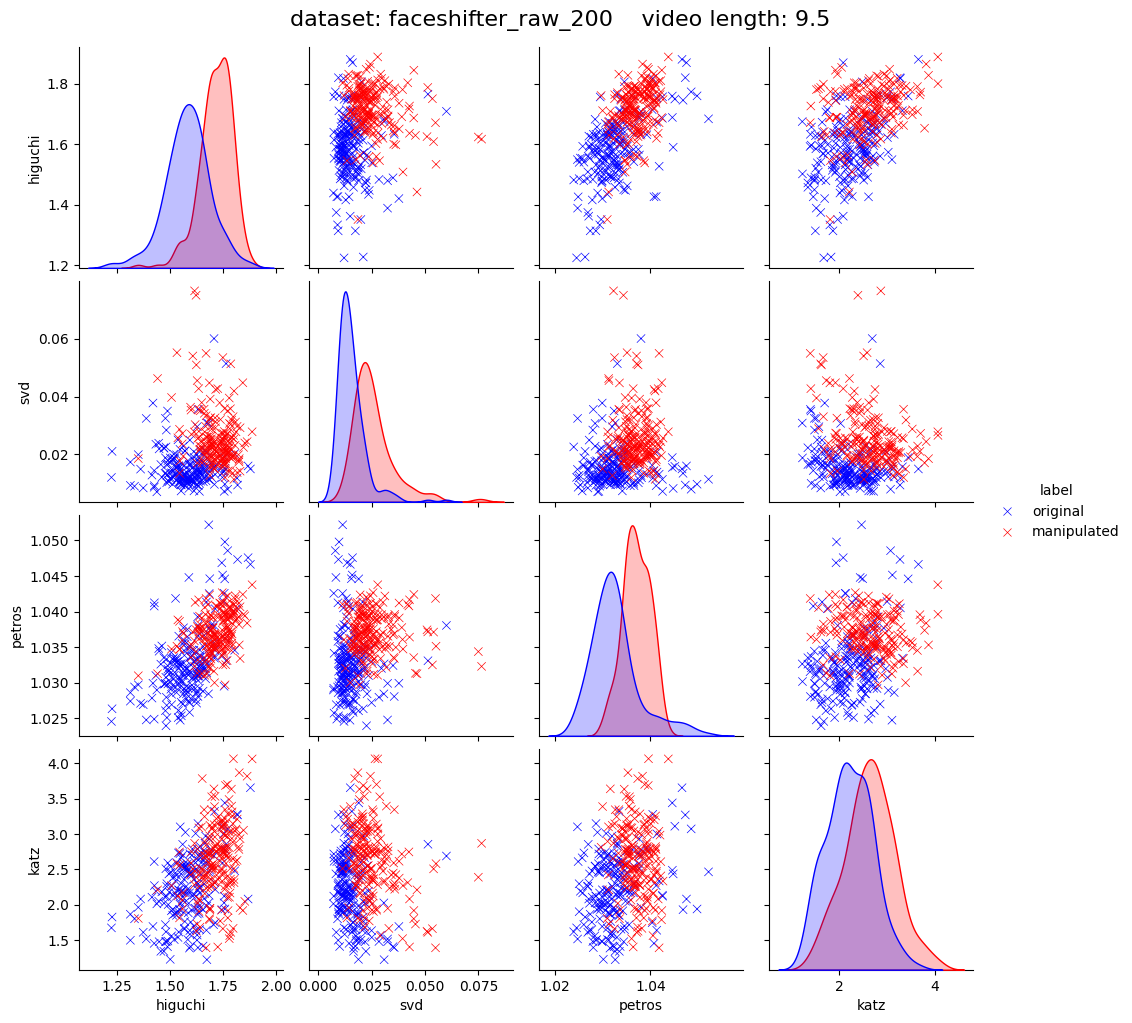

In [867]:
''' 
OPTIMIZED FEATURES: MATRIX
'''

features_to_include = ['higuchi', 'svd', 'petros', 'katz']

df_subset = df_combined[features_to_include + ['label']]

# Custom palette and markers for the labels
custom_palette = {
    'manipulated': 'red',
    'original': 'blue'
}
custom_markers = {'manipulated': 'x', 'original': 'x'}  

g = sns.pairplot(df_subset, hue='label', palette=custom_palette, markers=custom_markers)

g.fig.suptitle(f"dataset: {dataset[selector]}    video length: {max_length}", y=1.02, fontsize=16)
plt.show()


In [868]:
''' 
RESULTS
'''
print(f"dataset : {dataset[selector]}")
print(f"length : {max_length} \n")
print(f"initial accuracy: \t {accuracy_initial* 100:.2f}".replace('.', ','))
print(f"optimized accuracy: \t {accuracy_optimized* 100:.2f}".replace('.', ','))

dataset : faceshifter_raw_200
length : 9.5 

initial accuracy: 	 90,87
optimized accuracy: 	 93,91


# Analysis: Misclassification 

In [869]:
featurelist = ['bpm', 'zero','katz','svd','dfa','higuchi','petros']

misclassified_names = fn_names.union(fp_names)
misclassified_df = df_combined.loc[misclassified_names, featurelist]

print("Misclassified samples with selected feature values (bpm, katz, svd):")
print(misclassified_df)


Misclassified samples with selected feature values (bpm, katz, svd):
               bpm zero      katz       svd       dfa   higuchi    petros
178      86.481113   70  2.723363  0.016907  1.332083  1.690918  1.037424
396_272  86.055777   62  1.681648  0.021777  1.353696  1.642055  1.037321
468      81.355932  152  2.854797  0.051365  0.983084  1.765006  1.033081
598      83.584337  139  3.320041  0.015734  1.081389  1.710347   1.03345
623       90.09009   76  2.999078  0.013911  1.112901  1.752338  1.041398
635      87.649402  176  2.774596  0.011974  1.175271  1.697357  1.038157
969      87.719298   48   2.48659  0.015498  1.309892  1.688117  1.044618
985      76.119403   91  2.479063  0.020286  1.080201  1.805721   1.03456


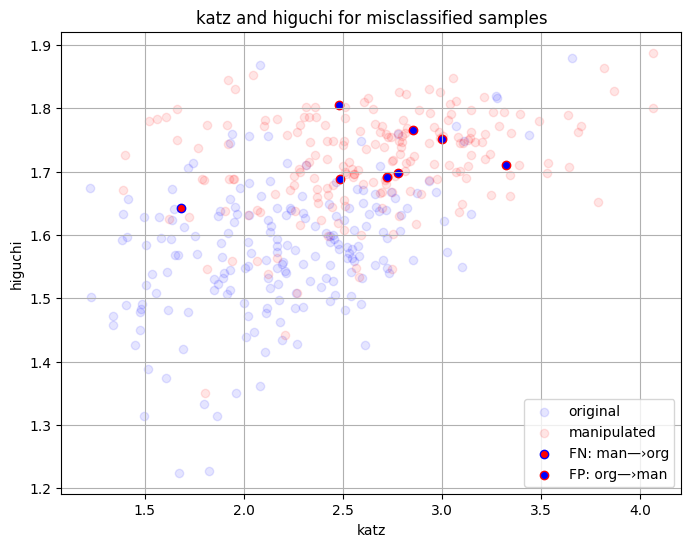

In [898]:

featurelist = ['bpm', 'zero','katz','svd','dfa','higuchi','petros']

df_fn = df_combined.loc[fn_names, featurelist]
df_fp = df_combined.loc[fp_names, featurelist]

x_feature = 'katz'
y_feature = 'higuchi'

plt.figure(figsize=(8, 6))


plt.scatter(df_original[x_feature], df_original[y_feature], color='blue', alpha=0.1, label='original')
plt.scatter(df_manipulated[x_feature], df_manipulated[y_feature], color='red', alpha=0.1, label='manipulated')

plt.scatter(df_fn[x_feature], df_fn[y_feature], color='red', edgecolors='blue', linewidths=1,alpha=1, label='FN: man—›org')
plt.scatter(df_fp[x_feature], df_fp[y_feature], color='blue', edgecolors='red', linewidths=1, alpha=1, label='FP: org—›man')

plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title(f'{x_feature} and {y_feature} for misclassified samples')

plt.legend()
plt.grid(True)
plt.show()
